In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC3_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param Definition des table et colonnes --> Dépendent de la DB
DB            = "Archive2018_2019_prod"
TABLE_ENTETE  = "Recette_entete_ticket"
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 4            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_ticket_max = 5000000   # MAX = 26.671.566 --- ~ 4 data / ticket

# @param Permet de faire varier l'analyse
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif
min_support    = 0         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
min_confidence = 1/5       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# GROUPEMENT D'ARTICLE

In [4]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE  + '''.KEY],
['''     + TABLE_ENTETE  + '''.''' + TABLE_MAGASIN + '''.KEY]
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(nbr_ticket_max) + '''
AND [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY],
[Recette_entete_ticket.Magasin.KEY]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 5000000
AND [Article_meti_HIST.Univers.KEY] != 388
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~272secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0                                   392                          2   
1                     

In [5]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 1s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [6]:
univers_correspondance = {}
deleted = set()
for item in df_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{3: 2}


In [7]:
start = time()

transactions      = []
actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    
    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            transactions.append(tuple(l))
        actual_key_ticket = key_tic
        l = []
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(key_univ)
transactions.append(tuple(l))
print(transactions[:20])

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(392, 148, 148), (174, 392, 294, 129, 183, 69, 357), (358, 393, 393, 457), (400, 357, 129), (394, 394, 110, 456, 468), (148, 357, 299), (437, 299), (121, 319, 396, 452, 219, 477, 477), (299, 299), (400, 400, 148, 148), (176, 212), (403, 148, 148, 403, 148, 148, 403, 148), (409, 357, 457), (251, 211, 409), (272, 148, 393), (294, 121, 457, 392), (392, 470, 418, 331), (151, 272, 392, 361, 231, 231), (403, 129, 392, 457, 120), (297, 294, 272)]
Time Taken to load transaction: ~27secondes


In [8]:
rec_article = {}
N = len(transactions)

for t in transactions:
    for art in t:
        if not str(art) in rec_article.keys():
            rec_article[str(art)] = 0
        rec_article[str(art)]+=1

for k in rec_article.keys():
    rec_article[k]/= N
print(N)

3623827


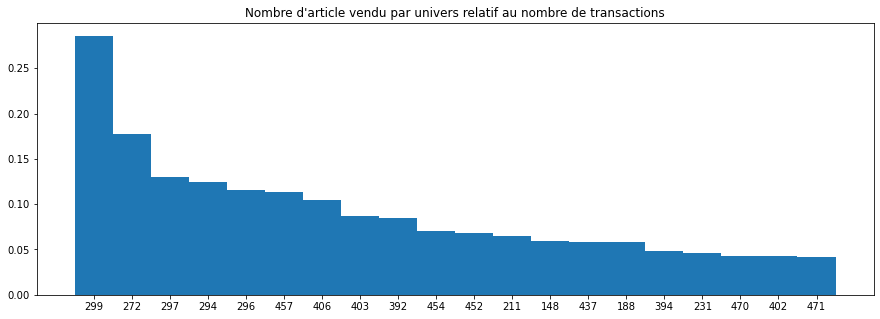

In [9]:
fig = plt.figure(figsize=(15, 5))

rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

nbr_univ = len(rec_article.keys())

plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
            ,list(rec_article.values())[:min(20, nbr_univ)],1)
        
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
if save_fig:
    plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
plt.show()

In [10]:
if do_analysis:
    data_rules = {}
    data_time  = {}
    for i_support in range(sup_iter+1):
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter

        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter

            print(min_confidence, end = '... ')

            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")


    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)

In [11]:
start = time()

min_supp = 1/nbr_univ if min_support == 0 else min_support
print(min_supp)
                     
_, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

0.002457002457002457
Time Taken to run Apriori Algorithm : ~71secondes


In [12]:
print(len(rules))
print(sum([r.support for r in rules])*0.05)
for rule in sorted(rules, key=lambda rule: rule.support):
    print(rule)

52
0.0139914101859719
{406, 452} -> {403} (conf: 0.276, supp: 0.002, lift: 4.631, conv: 1.299)
{403, 452} -> {406} (conf: 0.330, supp: 0.002, lift: 4.395, conv: 1.380)
{294, 296} -> {297} (conf: 0.243, supp: 0.003, lift: 2.217, conv: 1.176)
{319} -> {454} (conf: 0.243, supp: 0.003, lift: 4.590, conv: 1.251)
{408} -> {406} (conf: 0.229, supp: 0.003, lift: 3.046, conv: 1.199)
{294, 296} -> {299} (conf: 0.254, supp: 0.003, lift: 1.780, conv: 1.149)
{18} -> {297} (conf: 0.259, supp: 0.003, lift: 2.364, conv: 1.201)
{78} -> {57} (conf: 0.322, supp: 0.003, lift: 19.296, conv: 1.451)
{22} -> {297} (conf: 0.205, supp: 0.003, lift: 1.869, conv: 1.120)
{328} -> {461} (conf: 0.303, supp: 0.003, lift: 17.510, conv: 1.410)
{294, 299} -> {297} (conf: 0.201, supp: 0.003, lift: 1.834, conv: 1.114)
{438} -> {299} (conf: 0.400, supp: 0.003, lift: 2.808, conv: 1.430)
{408} -> {412} (conf: 0.258, supp: 0.003, lift: 9.938, conv: 1.313)
{52} -> {297} (conf: 0.269, supp: 0.003, lift: 2.456, conv: 1.218)
{298

In [18]:
conn = engine.connect()

for rule in sorted(rules, key=lambda rule: rule.lift):
#     if (not 272 in rule.lhs) and (not 272 in rule.rhs) and (not 271 in rule.lhs) and (not 271 in rule.rhs): 
#         continue

    print("\n\nRule : ", rule)
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.lhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))
    print('->')
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.rhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))

conn.close()



Rule :  {188} -> {272} (conf: 0.212, supp: 0.009, lift: 1.401, conv: 1.077)
 Univ_KEY   Univ_1 Univ_2 Univ_3 Univ_4
      188 BOISSONS BIERES   PILS   PILS
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {231} -> {272} (conf: 0.250, supp: 0.009, lift: 1.656, conv: 1.132)
 Univ_KEY   Univ_1      Univ_2                Univ_3                Univ_4
      231 BOISSONS SOFT DRINKS BOISSONS ENERGISANTES BOISSONS ENERGISANTES
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {296} -> {299} (conf: 0.240, supp: 0.015, lift: 1.683, conv: 1.128)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1       Univ_2      

 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {403} -> {406} (conf: 0.254, supp: 0.015, lift: 3.377, conv: 1.239)
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {271} -> {272} (conf: 0.521, supp: 0.005, lift: 3.448, conv: 1.772)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGA

 Univ_KEY          Univ_1      Univ_2 Univ_3 Univ_4
       78 PRET A CUISINER PATES   RIZ  PATES  PATES
->
 Univ_KEY          Univ_1  Univ_2                   Univ_3                   Univ_4
       57 PRET A CUISINER FROMAGE FROMAGES RAPES   COPEAUX FROMAGES RAPES   COPEAUX


In [14]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~423secondes


## Panier d'Articles par magasin

In [15]:
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]

    Magasin.KEY Magasin.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


In [16]:
all_mag_key = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_tra = {mag_key:[] for mag_key in all_mag_key}

start = time()

actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    key_mag  = item[2]

    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            all_mag_tra[key_mag].append(tuple(l))
        actual_key_ticket = key_tic
        l = []

    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(key_univ)
all_mag_tra[key_mag].append(tuple(l))

# environ 10s
print("Time Taken to run load transaction : ~" + str(int(time() - start)) + "secondes") 

Time Taken to run load transaction : ~33secondes


In [17]:
conn = engine.connect()
for mag_key in all_mag_key:
    start    = time()
    mag_lib  = all_mag_lib[mag_key]
    mag_tran = all_mag_tra[mag_key]
    

    mag_rec_article = {}

    for t in mag_tran:
        for art in t:
            if not str(art) in mag_rec_article.keys():
                mag_rec_article[str(art)] = 0
            mag_rec_article[str(art)]+=1

    for k in mag_rec_article.keys():
        mag_rec_article[k]/= len(mag_tran)
    print(len(mag_tran))
    
    
    mag_rec_article = {k: v for k, v in sorted(mag_rec_article.items(), key=lambda item: item[1], reverse = True)}
    mag_nbr_univ = len(mag_rec_article.keys())
    
    if len(mag_tran) < mag_nbr_univ**2:
        print("To less data ...")
        continue
    
    fig = plt.figure(figsize=(15, 5))
    plt.bar(list(mag_rec_article.keys())[:min(20, mag_nbr_univ)]
                ,list(mag_rec_article.values())[:min(20, mag_nbr_univ)],1)

    plt.title(mag_lib + ": Nombre d'article vendu par univers relatif au nombre de transactions")

    if save_fig:
        plt.savefig(save_folder+"/MAG-"+str(mag_key)+"-"+mag_lib+"-Proportion-Article.jpg")
    plt.show()
    
    min_supp = 1/mag_nbr_univ if min_support == 0 else min_support
    print(min_supp)
 
    print("Running Apriori")
    _, mag_rules = apriori(mag_tran, min_support=min_supp, min_confidence=min_confidence)
    
    print(len(mag_rules))
    for rule in sorted(mag_rules, key=lambda rule: rule.lift):
        print(rule)

    # environ 5s   
    print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
    

    for rule in sorted(mag_rules, key=lambda rule: rule.lift):
        print("\n\nRule : ", rule)

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

conn.close()    



KeyboardInterrupt



In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 